In [14]:
import numpy as np
import pandas as pd

In [15]:
df = pd.read_csv('3artist.csv')
df.head()

,Lyric,label,clean_lyrics
0,jhené aiko what's up been a minute since we ki...,Drake,jhené aiko minute kick catch bitch star love d...
1,produced by noah 40 shebib i can see it in y...,Drake,produce noah shebib eye angry regret get sh...
2,yeah i'm working on dying i'm upset fifty th...,Drake,yeah work die upset head disrespect offend ...
3,look i ain't never had a benzo nope i pushed m...,Drake,look be benzo nope push ac wit tintzo nosey ni...
4,aww man ho yes hahaha yeah can y'all hear me o...,Drake,aww man ho yes hahaha yeah you hear lovely nig...


In [27]:
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df['tokens'] = df['clean_lyrics'].apply(lambda x: x.split())

In [24]:
w2v_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    seed=42
)

 Logistic Regression Evaluation
Accuracy: 0.667
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.66      0.52      0.58        60
       Drake       0.70      0.88      0.78        60
Taylor Swift       0.63      0.60      0.62        60

    accuracy                           0.67       180
   macro avg       0.66      0.67      0.66       180
weighted avg       0.66      0.67      0.66       180



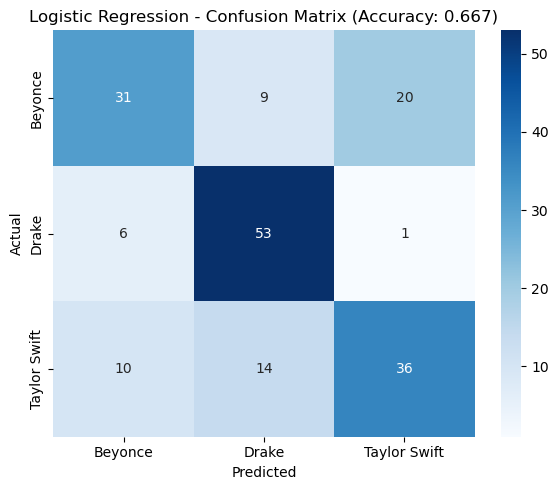

 SVM Evaluation
Accuracy: 0.661
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.76      0.47      0.58        60
       Drake       0.66      0.92      0.77        60
Taylor Swift       0.60      0.60      0.60        60

    accuracy                           0.66       180
   macro avg       0.67      0.66      0.65       180
weighted avg       0.67      0.66      0.65       180



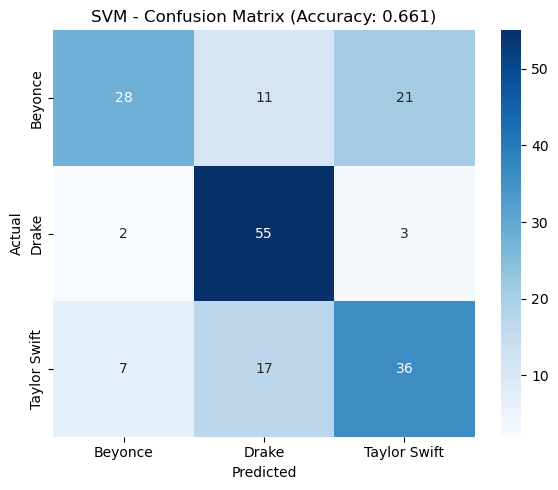

 Random Forest Evaluation
Accuracy: 0.706
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.66      0.62      0.64        60
       Drake       0.81      0.80      0.81        60
Taylor Swift       0.65      0.70      0.67        60

    accuracy                           0.71       180
   macro avg       0.71      0.71      0.71       180
weighted avg       0.71      0.71      0.71       180



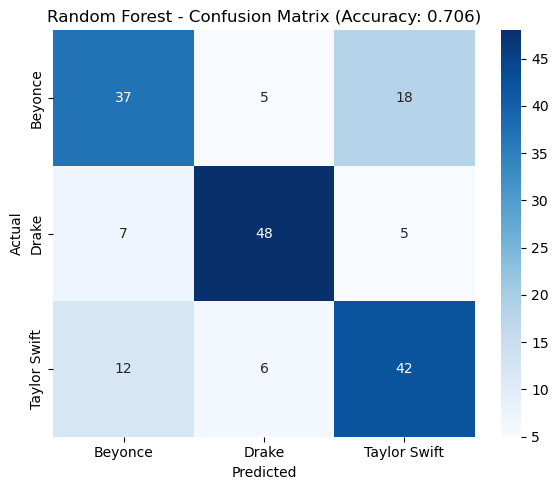

 Naive Bayes Evaluation
Accuracy: 0.567
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.73      0.45      0.56        60
       Drake       0.51      0.88      0.65        60
Taylor Swift       0.56      0.37      0.44        60

    accuracy                           0.57       180
   macro avg       0.60      0.57      0.55       180
weighted avg       0.60      0.57      0.55       180



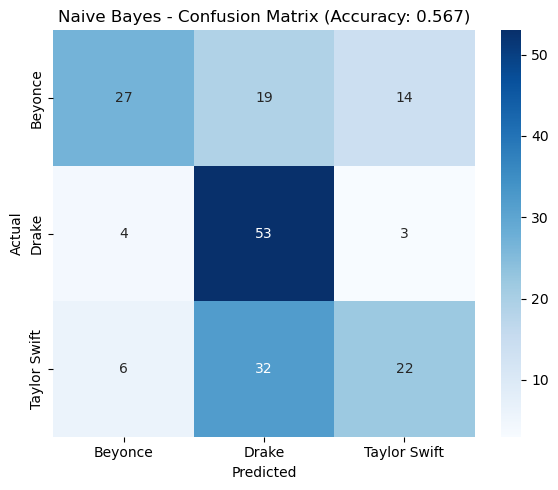

In [ ]:
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.dim = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.model.wv[token] for token in tokens if token in self.model.wv]
                    or [np.zeros(self.dim)], axis=0)
            for tokens in X
        ])


le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(
    df['tokens'], df['encoded_label'], test_size=0.2, stratify=df['encoded_label'], random_state=42
)

vectorizer = MeanEmbeddingVectorizer(w2v_model)
X_train_vec = vectorizer.transform(X_train_tokens)
X_test_vec = vectorizer.transform(X_test_tokens)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = round(accuracy_score(y_test, y_pred), 3)
    print(f" {name} Evaluation")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix (Accuracy: {acc})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()